In [122]:
%config InlineBackend.figure_format = 'retina'
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
from astropy.table import Table, vstack
from scipy.special import gammaincinv, gamma

plt.style.use('../notebooks/jpg.mplstyle')

labels = dict(
    m_g = r'$m_g$',
    m_r = r'$m_r$',
    m_i = r'$m_i$',
    mu_0_g_n1 = r'$\mu_0(g, n=1)\ \mathrm{\left[mag\ arcsec^{-2}\right]}$',
    mu_e_ave_g = r'$\bar{\mu}_\mathrm{eff}(g)\ \mathrm{\left[mag\ arcsec^{-2}\right]}$',
    mu_e_ave_r = r'$\bar{\mu}_\mathrm{eff}(g)\ \mathrm{\left[mag\ arcsec^{-2}\right]}$',
    mu_e_ave_i = r'$\bar{\mu}_\mathrm{eff}(g)\ \mathrm{\left[mag\ arcsec^{-2}\right]}$',
    r_e = r'$r_\mathrm{eff}$ [arcsec]',
    ell = 'Ellipticity'
)

In [4]:
data_path = '/Users/jgreco/local-io/hugs-data/synth-results'
fig_dir = '/Users/jgreco/local-io/figures/hugs-ana'
fig_label = 'blue-synths'

num_runs = 3

galcolors = ['blues', 'med', 'reds']
#galcolors = ['blues']
#galcolors = ['reds']

# combine synth results
synth_cat = []
synth_match = []
hugs_match = []

data = lambda fn: Table.read(os.path.join(data_path, fn))

for color in galcolors:
    for i in range(1, num_runs + 1):
        label = '-{}-0{}.csv'.format(color, i)
        synth_cat.append(data('synth-cat' + label))
        synth_match.append(data('synth-match' + label))
        hugs_match.append(data('hugs-match' + label))
        
synth_cat = vstack(synth_cat)
synth_match = vstack(synth_match)
hugs_match = vstack(hugs_match)

In [6]:
injected = synth_cat
recovered = synth_match
measured = hugs_match

x_par = 'r_e'
y_par = 'mu_e_ave_g'

dbin=[1.0, 0.5]
x_bin_pad=[1, 3]
y_bin_pad=[0, 3]

bins = [np.arange(np.floor(injected[x_par].min()) -\
                            x_bin_pad[0]*dbin[0],
                  np.ceil(injected[x_par].max()) +\
                          x_bin_pad[1]*dbin[0], dbin[0]),
        np.arange(np.floor(injected[y_par].min()) -\
                            y_bin_pad[0]*dbin[1],
                  np.ceil(injected[y_par].max()) +\
                          y_bin_pad[1]*dbin[1], dbin[1])]

x_centers = 0.5 * (bins[0][1:] + bins[0][:-1]) - 0.5*dbin[0]
y_centers = 0.5 * (bins[1][1:] + bins[1][:-1]) - 0.5*dbin[1]

In [7]:
H_injected, _, _ = np.histogram2d(injected[x_par],
                                  injected[y_par],
                                  bins=bins)
H_measured, _, _ = np.histogram2d(recovered[x_par],
                                  recovered[y_par],
                                  bins=bins)

H_injected[H_injected==0] = 1e-8
H_frac = H_measured/H_injected

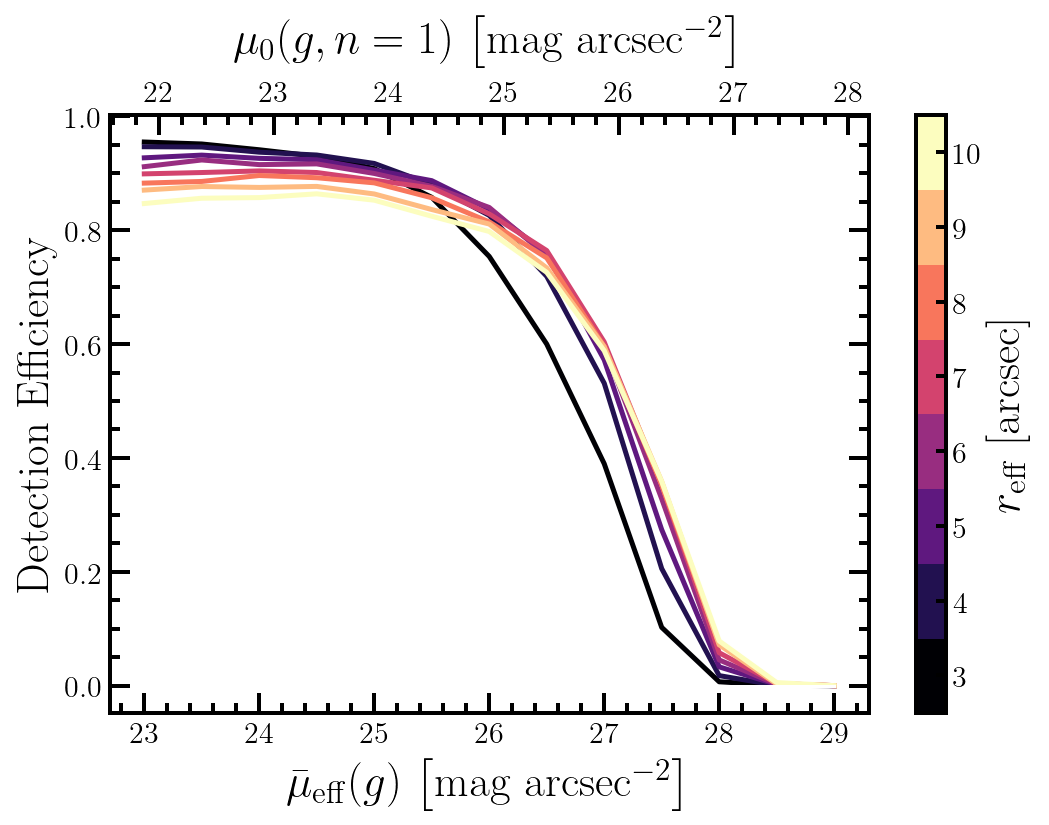

In [128]:

mu_vals = y_centers[1:-1]

colors = plt.cm.magma(np.linspace(0, 1, 9))

fig, ax = plt.subplots(figsize=(8.5, 5.5))

normalize = mcolors.Normalize(vmin=3, vmax=10)
colormap = plt.cm.magma

for i in range(1, 9):
    color = colormap(normalize(x_centers[i]))
    ax.plot(mu_vals, H_frac[i, 1:-1], c=color, lw=2.5);

ax.minorticks_on()

n = 1.0
b_n = gammaincinv(2. * n, 0.5)
f_n = gamma(2*n)*n*np.exp(b_n)/b_n**(2*n)
mu_0 = mu_vals + 2.5*np.log10(f_n) - 2.5*b_n/np.log(10)

ax2 = ax.twiny()
vals = [0] * len(mu_vals)
ax2.plot(mu_0, vals, c='w')
ax2.minorticks_on()


fs = 22.5

ax2.set_xlabel(labels['mu_0_g_n1'], fontsize=fs, labelpad=10);


ax.set_xlabel(labels['mu_e_ave_g'], fontsize=fs);

ax.set_ylabel('Detection Efficiency', fontsize=fs)

# Colorbar setup

colorparams = x_centers[1:9]
s_map = plt.cm.ScalarMappable(norm=normalize, cmap=colormap)
s_map.set_array(colorparams)

# If color parameters is a linspace, we can set boundaries in this way
halfdist = (colorparams[1] - colorparams[0])/2.0
boundaries = np.linspace(colorparams[0] - halfdist, colorparams[-1] + halfdist, len(colorparams) + 1)

# Use this to emphasize the discrete color values
cbar = fig.colorbar(s_map, spacing='proportional', ticks=colorparams, boundaries=boundaries, format='%2.2g') # format='%2i' for integer

cbar.ax.tick_params(length=5)
cbar.ax.set_ylabel(labels['r_e'], fontsize=fs)

fig.savefig('/Users/jgreco/local-io/figures/hugs-ana/completeness-1d.png', dpi=200)